https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb

Read in parquet: https://www.kaggle.com/sohier/getting-started-reading-the-data

In [1]:
from fastai.vision import *
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pretrainedmodels

from sklearn.model_selection import StratifiedKFold

import ImageDataAugmentation as ida

import cv2

In [2]:
#!pip install pyarrow==0.15.*
#!pip install nbdev
#!pip install pretrainedmodels

In [3]:
#!apt-get install -y libsm6 libxext6 libxrender-dev
#!pip install opencv-python

In [4]:
source = Path('/home/kaggle/bengaliai-cv19/input')

In [36]:
df = pd.DataFrame([('bird', 2, 2),
                   ('mammal', 4, np.nan),
                   ('arthropod', 8, 0),
                   ('bird', 2, np.nan)],
                  index=('falcon', 'horse', 'spider', 'ostrich'),
                  columns=('species', 'legs', 'wings'))
df

,species,legs,wings
falcon,bird,2,2.0
horse,mammal,4,NaN
spider,arthropod,8,0.0
ostrich,bird,2,NaN


In [39]:
df.groupby('species')['legs'].agg(lambda x: pd.Series.mode(x)[0]).to_frame()

,legs
species,
arthropod,8
bird,2
mammal,4


In [5]:
source


PosixPath('/home/kaggle/bengaliai-cv19/input')

In [6]:
df_label = pd.read_csv(source/'train.csv')
df_label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [7]:
cls_count=[df_label.grapheme_root.nunique(), df_label.vowel_diacritic.nunique(), df_label.consonant_diacritic.nunique()]
cls_count

[168, 11, 7]

In [8]:
train = pd.DataFrame(df_label['image_id'])
#train['tags'] = df_label['grapheme_root'].astype(str) #+' '+ df_label['vowel_diacritic'].astype(str) +' '+ df_label['consonant_diacritic'].astype(str)

#train['tags'] =  df_label['vowel_diacritic'].astype(str) 
#train['tags'] =  df_label['consonant_diacritic'].astype(str) 
# train.groupby(['grapheme_root','vowel_diacritic','consonant_diacritic']).count()

train = df_label.drop('grapheme', axis=1)

train['tag'] = train['grapheme_root'].astype(str)+'_'+train['vowel_diacritic'].astype(str)+'_'+train['consonant_diacritic'].astype(str)

In [9]:
n_splits=5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)

for fold, (train_idx, val_idx) in enumerate(skf.split(X=train, y=train['tag'].values)):
                    train['valid_kf_'+str(fold)] = 0
                    train.loc[val_idx, 'valid_kf_'+str(fold)] = 1
        

In [10]:
train.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,tag,valid_kf_0,valid_kf_1,valid_kf_2,valid_kf_3,valid_kf_4
0,Train_0,15,9,5,15_9_5,0,0,1,0,0
1,Train_1,159,0,0,159_0_0,0,0,0,0,1
2,Train_2,22,3,5,22_3_5,0,0,0,1,0
3,Train_3,53,2,2,53_2_2,0,0,0,0,1
4,Train_4,71,9,5,71_9_5,1,0,0,0,0


In [11]:
#train.describe()
#train.groupby(['grapheme_root','vowel_diacritic','consonant_diacritic'])['valid_kf_1'].sum()

# Load all

In [12]:
def read_all(file='train_image_data_crop_scaled_'):
    df = (pd.read_feather(source/(file+'0.feather'))
          .append(pd.read_feather(source/(file+'1.feather')))
          .append(pd.read_feather(source/(file+'2.feather')))
          .append(pd.read_feather(source/(file+'3.feather')))
         )
    df.reset_index(inplace=True,drop = True)
    return df

df_train = read_all('train_image_data_crop_scaled_')

# Load one

In [13]:
def read_one(file='train_image_data_crop_scaled_0.feather'):
    df = pd.read_feather(source/(file))
    df.reset_index(inplace=True,drop = True)
    return df
    
df_train = read_one('train_image_data_crop_scaled_0.feather') #train_image_data_crop_scaled_0
#df_train = read_one('train_image_data_resize_only_0.feather')#'train_image_data_crop_scaled_0.feather') #train_image_data_crop_scaled_0

#df_train = pd.read_parquet('input/train_image_data_0.parquet')
#df_train.reset_index(inplace=True,drop = True)#
    

In [14]:
#df_train=df_train.append(pd.read_feather(source/('train_image_data_resize_only_0.feather')))
#df_train=df_train.append(pd.read_feather(source/('train_image_data_resize_only_1.feather')))
#df_train=df_train.append(pd.read_feather(source/('train_image_data_resize_only_2.feather')))
#df_train=df_train.append(pd.read_feather(source/('train_image_data_resize_only_3.feather')))

In [13]:
df_train.shape

(200840, 16385)

In [14]:
#train.groupby(['grapheme_root','vowel_diacritic','consonant_diacritic']).count().sort_values('image_id', ascending=False)

# Merge with tags

In [15]:
df_train = df_train.merge(train, on='image_id')

In [16]:
df_train['fn'] = df_train.index

In [17]:
df_train.head(10)

,image_id,0,1,2,3,4,5,6,7,8,...,grapheme_root,vowel_diacritic,consonant_diacritic,tag,valid_kf_0,valid_kf_1,valid_kf_2,valid_kf_3,valid_kf_4,fn
0,Train_0,251,252,251,252,252,253,252,252,252,...,15,9,5,15_9_5,0,0,1,0,0,0
1,Train_1,255,255,255,255,255,255,255,255,255,...,159,0,0,159_0_0,0,0,0,0,1,1
2,Train_2,253,253,254,254,254,253,253,252,252,...,22,3,5,22_3_5,0,0,0,1,0,2
3,Train_3,249,251,252,251,250,250,252,251,250,...,53,2,2,53_2_2,0,0,0,0,1,3
4,Train_4,255,255,255,255,255,255,255,255,255,...,71,9,5,71_9_5,1,0,0,0,0,4
5,Train_5,248,248,247,246,247,247,247,245,245,...,153,9,0,153_9_0,0,0,1,0,0,5
6,Train_6,253,253,254,253,252,252,252,252,252,...,52,2,0,52_2_0,0,0,0,0,1,6
7,Train_7,251,250,250,249,248,247,248,250,250,...,139,3,0,139_3_0,0,0,1,0,0,7
8,Train_8,253,253,253,252,250,248,248,246,244,...,67,0,0,67_0_0,0,0,0,1,0,8
9,Train_9,254,254,254,254,254,254,253,253,253,...,64,7,1,64_7_1,0,0,0,1,0,9


In [18]:
#df_train[df_train['grapheme_root']==48][df_train['vowel_diacritic']==4][df_train['consonant_diacritic']==0]

In [19]:
#data.get(4526)

In [20]:
#### df_train.groupby(['tag'])['valid_kf_4'].sum()

In [21]:
SIZE = 128

In [22]:
tfms = get_transforms(do_flip=False,max_zoom=1, xtra_tfms=[cutout(n_holes=(1,4), length=(16, 16), p=.5)]) #,rand_zoom(scale=(.8,1))
#tfms = ([cutout(n_holes=(1,4), length=(16, 16), p=.5)],[])

tfms[0][0].kwargs['padding_mode'] = 'zeros'

tfms[1][0].kwargs['padding_mode'] = 'zeros'

In [23]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'zeros'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (cutout), kwargs={'n_holes': (1, 4), 'length': (16, 16)}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={'padding_mode': 'zeros'}, p=1.0, resolved={}, do_

In [24]:
#https://www.kaggle.com/melissarajaram/model-ensembling-and-transfer-learning
class PixelImageItemList(ImageList):
    
    def open(self,fn):
        img_pixel = self.inner_df.loc[self.inner_df['fn'] == int(fn[2:])].values[0,1:(SIZE*SIZE+1)] #.values[0,1:32333]#
        img_pixel = img_pixel.reshape(SIZE,SIZE) #.reshape(137,236)#
        #img_pixel = np.stack((img_pixel,)*3,axis=-1)
        return vision.Image((pil2tensor(img_pixel,np.float32).div_(255)-1).abs_())

In [25]:
class PixelImageItemList_full(ImageList):
    
    def __init__(self, myimages = {}, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.myimages = myimages 
    
    def open(self,fn):
        return self.myimages.get(fn)
    
    @classmethod
    def from_df(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix:str='', **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        res = super().from_df(df, path=path, cols=cols, **kwargs)
        
        # full load of all images
        for i, row in tqdm(df.drop(labels=['image_id','fn','grapheme_root','vowel_diacritic','consonant_diacritic',
                                          'tag','valid_kf_0','valid_kf_1','valid_kf_2','valid_kf_3','valid_kf_4'],axis=1).iterrows()):
            # Numpy to Image conversion from
            # https://www.kaggle.com/heye0507/fastai-1-0-with-customized-itemlist
            img_pixel = row.values.reshape(SIZE,SIZE) #.reshape(137,236)
            img_pixel = np.stack((img_pixel,)*1,axis=-1)
            
            '''
            lvl = 0
            go_on = True
            while(go_on):
                if np.sum(img_pixel[-1,:,0])==0:
                    lvl+=1
                    img_pixel=np.roll(img_pixel,1,axis=0)
                else:
                    go_on=False
            #img_pixel[lvl:,:,0]=img_pixel[:-lvl,:,0]
            #img_pixel[:lvl,:,0]=0
            
           # img_pixel = np.stack((img_pixel,)*5,axis=-1)
             ## override Top
            img_pixel[:16+lvl,:,1]=0
            ## Bottom
            img_pixel[16+lvl:,:,2]=0
            ## Left
            img_pixel[:,14:,3]=0#[:,14:]=0
            ## Right
            img_pixel[:,:14,4]=0#[:,:14]=0
            # remove original layer
           # img_pixel=img_pixel[:,:,1:]
            '''
            
            
            #https://discuss.pytorch.org/t/how-to-calculate-the-gradient-of-images/1407/5
            #Black and white input image x, 1x1xHxW
            a = torch.Tensor([[1, 0, -1],
            [2, 0, -2],
            [1, 0, -1]])

            x=pil2tensor(img_pixel,np.float32).div_(255).unsqueeze(0)

            a = a.view((1,1,3,3))
            G_x = F.conv2d(x, a, padding=1)

            b = torch.Tensor([[1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]])

            b = b.view((1,1,3,3))
            G_y = F.conv2d(x, b, padding=1)

            G = torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
            #res = P(G)
            #
            PI = torch.acos(torch.Tensor([-1]))
            #D = ((torch.round((torch.atan2(G_y, G_x) * 180 / PI) / 45) * 45) + 180) % 180
            D1 = ((torch.round((torch.atan2(G_x, G_y) * 180 / PI) / 45) * 45) + 180) % 180
            D2 = ((torch.round((torch.atan2(G_y, G_x) * 180 / PI) / 45) * 45) + 180) % 180
            
            limg = torch.cat((pil2tensor(img_pixel,np.float32).div_(255),D1.squeeze(0).div_(180),D2.squeeze(0).div_(180)))
            
            #print(D)
           # vision.Image(pil2tensor(img_pixel,np.float32).div_(255)).show()
            #vision.Image(G_x.squeeze(0)).show()
            #vision.Image(G_y.squeeze(0)).show()
            #vision.Image(G.squeeze(0)).show()
           # vision.Image(D1.squeeze(0)).show()
           # vision.Image(D2.squeeze(0)).show()
            
            
            #print(img_pixel[:,:,1][6])
            #print(img_pixel[:,:,2][6])
            #print(img_pixel[:,:,3][6])
            #print(img_pixel[:,:,4][6])
           # break
            
            res.myimages[res.items[i]]=vision.Image(limg) 
            
            
            #res.myimages[res.items[i]]=vision.Image(pil2tensor(img_pixel,np.float32).div_(255))

            
        return res

In [26]:
%%time
piil = PixelImageItemList.from_df(df=df_train,path='.',cols='fn')
#piil = PixelImageItemList_full.from_df(df=df_train,path='.',cols='fn')

CPU times: user 473 ms, sys: 9.74 ms, total: 483 ms
Wall time: 482 ms


In [27]:
#df_train.tags

In [27]:
bs = 64
valid_col = 'valid_kf_2'
data = (piil#
        .split_by_rand_pct(0.2)
        #.label_from_df(cols='tags')#,label_delim=' ')
        #.split_from_df(col = valid_col)
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(tfms, padding_mode='zeros')#, size=(96,168)([cutout(n_holes=(1,4), length=(16, 16), p=.5),rand_zoom(scale=(.8,1))],[]), padding_mode='zeros')#tfms) #, size=128)
        .databunch(bs=bs).normalize(imagenet_stats)) #mnist_stats

'''(piil
        .split_by_rand_pct(0.2)
        .label_from_df(cols='tags',label_delim=' ')
        .databunch(bs=32))'''

"(piil\n        .split_by_rand_pct(0.2)\n        .label_from_df(cols='tags',label_delim=' ')\n        .databunch(bs=32))"

In [28]:
#data.train_dl.dl.dataset.tfms

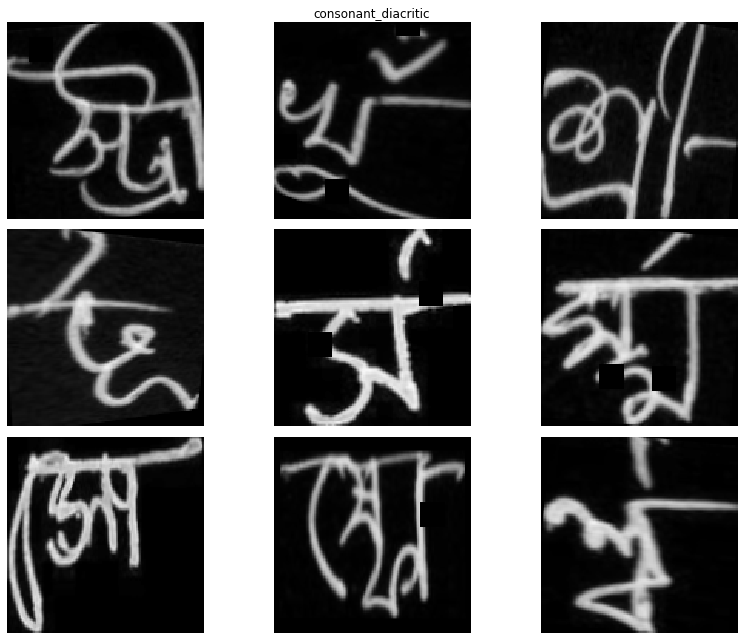

In [29]:
data.show_batch(rows=3, figsize=(12,9))

In [30]:
#data

In [31]:
leak=0.1
best_architecture = nn.Sequential(
            conv_layer(3,32,stride=1,ks=3,leaky=leak),
            conv_layer(32,32,stride=2,ks=3,leaky=leak),
            conv_layer(32,32,stride=2,ks=5,leaky=leak),
            nn.Dropout(0.4),

            conv_layer(32,32,stride=1,ks=3,leaky=leak),
            conv_layer(32,32,stride=2,ks=3,leaky=leak),
            conv_layer(32,32,stride=2,ks=5,leaky=leak),
            nn.Dropout(0.4),

            conv_layer(32,64,stride=1,ks=3,leaky=leak),
            conv_layer(64,64,stride=2,ks=3,leaky=leak),
            conv_layer(64,64,stride=2,ks=5,leaky=leak),
            nn.Dropout(0.4),

            Flatten(),
            nn.Linear(64, 32),#
            relu(inplace=True),
            nn.BatchNorm1d(32),
            nn.Dropout(0.4),
            nn.Linear(32,168)
            
    )

In [32]:
batch_size = 5
nb_digits = 10
# Dummy input that HAS to be 2D for the scatter (you can use view(-1,1) if needed)
y = torch.LongTensor(batch_size).random_() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits)

print(y, y.unsqueeze(1))

# In your for loop
y_onehot.zero_()
y_onehot.scatter_(1, y.unsqueeze(1),1)


print(y_onehot)

F.one_hot(y, num_classes=10)

tensor([6, 6, 5, 4, 5]) tensor([[6],
        [6],
        [5],
        [4],
        [5]])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])


tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [33]:
'''#https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/4
def y_onehot(y, cardinality):
    #print('in1H:',y, batch_size, cardinality)
    batch_size = y.shape[0]
    out = torch.FloatTensor(batch_size, cardinality).cuda()
    out.zero_()
    try:
        out.scatter_(1, y.unsqueeze(1),1)
    except:
        print(out,y)
        
        print(out.shape,y.shape)
    
    return out'''

#https://www.kaggle.com/mnpinto/bengali-ai-fastai2-starter-lb0-9598
# Loss function
'''class Loss_combine(Module):
    def __init__(self, func=F.cross_entropy, weights=[2, 1, 1]):
        self.func, self.w = func, weights

    def forward(self, xs, *ys):
        for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
            print(x, y)
            if i == 0: loss = w*self.func(x, y) 
            else: loss += w*self.func(x, y) 
        return loss'''


#https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        return 0.5*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.25*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
          0.25*F.cross_entropy(x3,y[:,2],reduction=reduction)

    

class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [34]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [35]:
#https://github.com/osmr/imgclsmob/blob/master/pytorch/pytorchcv/models/common.py

def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.
    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)


class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    round_mid : bool, default False
        Whether to round middle channel number (make divisible by 8).
    activation : function, or str, or nn.Module, default 'relu'
        Activation function after the first convolution.
    out_activation : function, or str, or nn.Module, default 'sigmoid'
        Activation function after the last convolution.
    """
    def __init__(self,
                 channels,
                 reduction=16,
                 round_mid=False,
                 mid_activation=(lambda: nn.ReLU(inplace=True)),
                 out_activation=(lambda: nn.Sigmoid())):
        super(SEBlock, self).__init__()
        mid_channels = channels // reduction if not round_mid else round_channels(float(channels) / reduction)

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_channels,
            bias=True)
        self.activ = nn.ReLU(inplace=True)
        
        self.conv2 = conv1x1(
            in_channels=mid_channels,
            out_channels=channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        identity = x
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        x = x + identity
        return x

In [36]:
#arch = models.densenet121 #resnet50
import torchvision.models as torch_models

#arch = torch_models.resnext50_32x4d #
arch = torch_models.resnext101_32x8d #


def se_resnext50(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained=pretrained)
    return model
#arch = models.cadene_models.se_resnext50_32x4d(pretrained=True)

In [37]:
class SAI(nn.Module):
    ''' SelfAttention with Identity '''
    
    def __init__(self, nf):
        super(SAI, self).__init__()
        
        self.sa = PooledSelfAttention2d(nf)
        self.bn = nn.BatchNorm2d(nf)
        self.do = nn.Dropout(0.4),
        
        
    def forward(self, x):
        ident = x
        out = self.sa(x)
        out = ident + out
        
        out = self.do(self.bn(out)) #
        
        return nn.ReLU(out)
    

In [38]:
class HeadBlock0(nn.Module):
    
    def __init__(self, nf, nc):
        super(HeadBlock0, self).__init__()
        
        self.head1 = create_head(nf, 1024, bn_final = True)
        self.at1 = SelfAttention(nf//4)
        self.rl1 = nn.LeakyReLU(0.1, inplace=True)
        self.lin1 = nn.Linear(1024, nc[0])
        
        self.head2 = create_head(nf, 1024, bn_final = True)
        self.at2 = SelfAttention(nf//4)
        self.rl2 = nn.LeakyReLU(0.1, inplace=True)
        self.lin2 = nn.Linear(1024, nc[1])
        
        self.head3 = create_head(nf, 1024, bn_final = True)
        self.at3 = SelfAttention(nf//4)
        self.rl3 = nn.LeakyReLU(0.1, inplace=True)
        self.lin3 = nn.Linear(1024, nc[2])
        
        
    def forward(self, x):
        
        x1 = self.head1(x)
        x1 = self.at1(x1)
        x1 = self.rl1(x1)
        x1 = self.lin1(x1) 
        
        x2 = self.head2(x)
        x2 = self.at2(x2)
        x2 = self.rl2(x2)
        x2 = self.lin2(x2) 
        
        x3 = self.head3(x)
        x3 = self.at3(x3)
        x3 = self.rl3(x3)
        x3 = self.lin3(x3) 
        
        return x1, x2, x3
    
    
class HeadBlock(nn.Module):
    
    def __init__(self, nf, nc):
        super(HeadBlock, self).__init__()
        
        self.se1 = SEBlock(nf//2)
        #self.at1 = SEBlock(nf//2)
        self.head1 = create_head(nf, nc[0])
        #self.sa1 = SelfAttention(nf//4)
        self.se2 = SEBlock(nf//2)
        #self.at2 = SEBlock(nf//2)
        self.head2 = create_head(nf, nc[1])
        #self.sa2 = SelfAttention(nf//4)
        self.se3 = SEBlock(nf//2)
        #self.at3 = SEBlock(nf//2)
        self.head3 = create_head(nf, nc[2])
        #self.sa3 = SelfAttention(nf//4)
        
        
    def forward(self, x):
        x1 = self.se1(x)
        ##x1 = self.at1(x1)
        x1 = self.head1(x1)
        
        x2 = self.se2(x)
        ##x2 = self.at2(x2)
        x2 = self.head2(x2)
        
        x3 = self.se3(x)
        ##x3 = self.at3(x3)
        x3 = self.head3(x3)
        
        return x1, x2, x3

class HeadBlock2(nn.Module):
    
    def __init__(self, nf, nc):
        super(HeadBlock2, self).__init__()
        
        self.head1 = create_head(nf, nc[0])
        self.head2 = create_head(nf, nc[1])
        self.head3 = create_head(nf, nc[2])
        
        self.rl1 = nn.LeakyReLU(0.1, inplace=True)
        self.rl2 = nn.LeakyReLU(0.1, inplace=True)
        self.rl3 = nn.LeakyReLU(0.1, inplace=True)
        
        self.bn1 = nn.BatchNorm1d(nc[0])
        self.bn2 = nn.BatchNorm1d(nc[1])
        self.bn3 = nn.BatchNorm1d(nc[2])
        
        #self.flatt1 = Flatten(nc[0])
        #self.flatt2 = Flatten(nc[1])
        #self.flatt3 = Flatten(nc[2])
        self.att = SelfAttention(sum(nc))
        self.head4 = nn.Linear(sum(nc)+nc[0], nc[0])
        self.head5 = nn.Linear(sum(nc)+nc[1], nc[1])
        self.head6 = nn.Linear(sum(nc)+nc[2], nc[2])
        
        
    def forward(self, x):
        x1 = self.head1(x)
        x2 = self.head2(x)
        x3 = self.head3(x)
        
        x1 = self.bn1(self.rl1(x1))
        x2 = self.bn2(self.rl2(x2))
        x3 = self.bn3(self.rl3(x3))
        
        f = torch.cat([(x1),(x2),(x3)],1)
        
        b = self.att(f)
        
        x4 = self.head4(torch.cat([x1 , b], 1))
        x5 = self.head5(torch.cat([x2 , b], 1))
        x6 = self.head6(torch.cat([x3 , b], 1))
        
        return x4, x5, x6


    
''' (0): AdaptiveConcatPool2d(
          (ap): AdaptiveAvgPool2d(output_size=1)
          (mp): AdaptiveMaxPool2d(output_size=1)
        )
        (1): Flatten()
        (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.25, inplace=False)
        (4): Linear(in_features=4096, out_features=512, bias=True)
        (5): ReLU(inplace=True)
        (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Dropout(p=0.5, inplace=False)
        (8): Linear(in_features=512, out_features=7, bias=True)
'''
    
def threeHeads(nf, nc):
    layers =[HeadBlock0(nf,nc)]
    return nn.Sequential(*layers)

In [39]:
#https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964#MixUp
class MixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3].long()), self.crit(output,target[:,3:6].long())
            d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
        else:  d = self.crit(output, target)
        if self.reduction == 'mean':    return d.mean()
        elif self.reduction == 'sum':   return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

In [40]:
class CutMixCallback(LearnerCallback):
    "Callback that creates the cutmixed input and target."
    def __init__(self, learn:Learner, α:float=1., stack_y:bool=True, stack_x:bool=True):
        super().__init__(learn)
        self.α,self.stack_y,self.stack_x = α,stack_y,stack_x

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train: return
        self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        lambd = np.random.beta(self.α, self.α)
        lambd = max(lambd, 1- lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)

        x1, y1 = last_input[shuffle], last_target[shuffle]
        #Get new input
        last_input_size = last_input.shape
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input.size(), lambd)
        new_input = last_input.clone()
        new_input[:, ..., bby1:bby2, bbx1:bbx2] = last_input[shuffle, ..., bby1:bby2, bbx1:bbx2]
        lambd = last_input.new([lambd])
        if self.stack_x:
            lambd = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
            lambd = last_input.new([lambd])
        if self.stack_y:
            new_target = torch.cat([last_target.float(), y1.float(),
                                lambd.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [41]:
class Loss_dist(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target,reduction='mean'):
        x1,x2,x3 = input
        #print(x2.shape,target.shape)
        #print(target.long())
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        #print(x2,y[:,1])
        #return 0.5*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.25*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
        #  0.25*F.cross_entropy(x3,y[:,2],reduction=reduction)
        
        #print('COS: ',F.cosine_similarity(x2,y_onehot(y[:,1], x2.shape[1]),1))
        #print('ENT: ',F.log_softmax(x2,1))
        
        bs = x1.shape[0]
        t = 1
        #print('bs', bs)
        
        #print('OHE',F.one_hot(y[:,0], num_classes = x1.shape[1]))
        #print('cos_sim',F.cosine_similarity(x1,F.one_hot(y[:,0], num_classes = x1.shape[1]),1).exp())
        loss = [None]*3
        for i, x_i in enumerate([x1,x2,x3]):
            num_classes = x_i.shape[1]
                        
            cos_sim_exp_1 = (F.cosine_similarity(x_i,F.one_hot(y[:,i], num_classes = num_classes),1)*t).exp()
            #cos_sim_exp_1 = torch.pow(x_i-F.one_hot(y[:,i], num_classes = num_classes), 2).sum(0).exp()
            cos_sim_exp_1_sum = cos_sim_exp_1.sum()
            #cos_sim_exp_2 = (-F.cosine_similarity(x_i,F.one_hot(y[:,i], num_classes = num_classes),1)).exp()
            #cos_sim_exp_2_sum = cos_sim_exp_2.sum()

            softmax_1 = cos_sim_exp_1 / (cos_sim_exp_1_sum-cos_sim_exp_1)
            #softmax_2 = cos_sim_exp_2 / (cos_sim_exp_2_sum-cos_sim_exp_2)

            ll_1 = -softmax_1.log()
            #ll_2 = -softmax_2.log()

            loss[i] = (ll_1.sum()/bs)*0.5 + (0.5*F.cross_entropy(x1,y[:,0],reduction=reduction) + 0.25*F.cross_entropy(x2,y[:,1],reduction=reduction) + \
                      0.25*F.cross_entropy(x3,y[:,2],reduction=reduction))*0.5
        
        
        #print('sm_1', softmax_1)
        #print('ll_1',ll_1)
                
        #print('new_loss', loss)
        
        #print('softmax',F.softmax(F.cosine_similarity(x1,F.one_hot(y[:,0], num_classes = x1.shape[1]),1),dim=0))
        #print('c_ent',F.cross_entropy(x1,y[:,0],reduction=reduction))
        
                
        return 0.5*loss[0]+0.25*loss[1]+0.25*loss[2]
        
        
        #print('XXX 1hot:', y_onehot(y[:,1], bs, x2.shape[1]))
        #return 0.5*F.cosine_embedding_loss(x1,y_onehot(y[:,0], x1.shape[1]),y[:,0]) + \
        #       0.25*F.cosine_embedding_loss(x2,y_onehot(y[:,1], x2.shape[1]),y[:,1]) + \
        #       0.25*F.cosine_embedding_loss(x3,y_onehot(y[:,2], x3.shape[1]),y[:,2])
        #print(F.cosine_similarity(x1,y_onehot(y[:,0], bs, x1.shape[1]),1).unsqueeze(1))
        #print('##',F.cosine_similarity(x1,y_onehot(y[:,0], bs, x1.shape[1]),1).unsqueeze(1).shape,'##',x1, x1.shape)
        #print('##mean##',F.cosine_similarity(x1,y_onehot(y[:,0], bs, x1.shape[1]),1).mean())
        #print('##cos_l##',F.cosine_embedding_loss(x1,y_onehot(y[:,0], bs, x1.shape[1]),y[:,0]))
        #print('##cent##',F.cross_entropy(x1,y[:,0],reduction=reduction))
        #return 0.5*F.cosine_similarity(x1,y_onehot(y[:,0], x1.shape[1]),1).abs().mean() + \
        #       0.25*F.cosine_similarity(x2,y_onehot(y[:,1], x2.shape[1]),1).abs().mean() + \
        #       0.25*F.cosine_similarity(x3,y_onehot(y[:,2], x3.shape[1]),1).abs().mean()
    

In [42]:
#arch

In [43]:
# create learner
#Loss_combine(),torch.nn.BCEWithLogitsLoss()
#se_resnext50

learn = cnn_learner(data, arch, cut=-2, custom_head=threeHeads(4096, cls_count), loss_func = Loss_combine(),metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()]).to_fp16()


#learn.freeze()
learn.clip_grad = 1.0
#learn.split([learn.model[1]])
#learn.unfreeze()

In [44]:
learn.unfreeze()
for i in range(3):    
    #learn.model[0][4][i].add_module('self_se1',SEBlock(256)) 
    #learn.model[0][4][i].add_module('self_att1',PooledSelfAttention2d(256)) #PooledSelfAttention2d
    learn.model[0][4][i].add_module('self_att1',SAI(256)) #PooledSelfAttention2d

for i in range(4):    
    #learn.model[0][5][i].add_module('self_se2',SEBlock(512)) 
    #learn.model[0][5][i].add_module('self_att2',PooledSelfAttention2d(512)) #PooledSelfAttention2d
    learn.model[0][5][i].add_module('self_att2',SAI(512)) #PooledSelfAttention2d

for i in range(23): #23   #6 
    #learn.model[0][6][i].add_module('self_se3',SEBlock(512)) 
    #learn.model[0][6][i].add_module('self_att3',PooledSelfAttention2d(512)) #PooledSelfAttention2d
    learn.model[0][6][i].add_module('self_att3',SAI(512)) #PooledSelfAttention2d

for i in range(3):    
    #learn.model[0][7][i].add_module('self_se4',SEBlock(512)) 
    #learn.model[0][7][i].add_module('self_att4',PooledSelfAttention2d(512)) #PooledSelfAttention2d
    learn.model[0][7][i].add_module('self_att4',SAI(512)) #PooledSelfAttention2d


In [45]:
#learn.model

In [46]:
#learn.freeze()
#learn.to_fp32()
learn.lr_find()

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-03
Min loss divided by 10: 7.59E-04


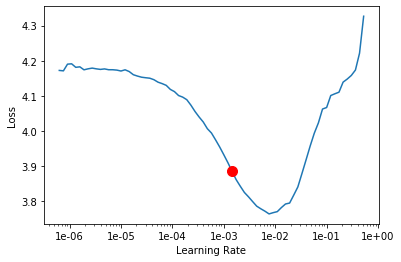

In [47]:
learn.recorder.plot(suggestion=True)

In [48]:
lr = 1e-2 #2
n_cycle = 10


In [ ]:
csvlogger = callbacks.CSVLogger(learn,'learn_log_2')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
#learn.fit(1,1e-4) #slice(lr)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, MixUpCallback(learn), csvlogger]) #,pct_start=0.0) 


epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.225675,0.386925,0.793842,0.926623,0.956843,0.867787,17:15
1,1.109261,0.320497,0.851140,0.957116,0.939664,0.899765,17:17
2,1.030468,0.233991,0.880839,0.947805,0.957951,0.916858,17:18


In [ ]:
lr = 1e-3 #2
n_cycle = 10

In [ ]:
csvlogger = callbacks.CSVLogger(learn,'learn_log_3')

reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'valid_loss', mode = 'auto', patience = 2, factor = 0.2, min_delta = 0)
#learn.fit(1,1e-4) #slice(lr)
learn.fit_one_cycle(n_cycle, slice(lr), callbacks=[reduceLR, MixUpCallback(learn), csvlogger]) #,pct_start=0.0) 

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
#learn.save('mymod_10E_SAI_mix_100d_Inv_0pad_2cos')

In [ ]:
#learn.export('export_mymod_10E_SAI_mix_100d_Inv_0pad_2cos.pkl')

# Pred train and valid

In [ ]:
# https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L370
def my_validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler:Optional[CallbackHandler]=None,
             pbar:Optional[PBar]=None, average=False, n_batch:Optional[int]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    model.eval()
    with torch.no_grad():
        val_losses,nums = [],[]
        grapheme_root, vowel_diacritic, consonant_diacritic = torch.Tensor(),torch.Tensor(),torch.Tensor()# = [],[],[]
        if cb_handler: cb_handler.set_dl(dl)
        for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
            if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
            val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler)[0]
            #val_losses.append(val_loss)
            
            #print(val_loss[0].shape,val_loss[1].shape,val_loss[2].shape)
            #grapheme_root.append(val_loss[0])
            #vowel_diacritic.append(val_loss[1])
            #consonant_diacritic.append(val_loss[2])
            grapheme_root = torch.cat((grapheme_root,val_loss[0]))
            vowel_diacritic = torch.cat((vowel_diacritic,val_loss[1]))
            consonant_diacritic = torch.cat((consonant_diacritic,val_loss[2]))
            
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            if cb_handler and cb_handler.on_batch_end(grapheme_root[-1]): break
            #if cb_handler and cb_handler.on_batch_end(val_losses[-1]): break
            if n_batch and (len(nums)>=n_batch): break
        nums = np.array(nums, dtype=np.float32)
        #if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        #else:       
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [ ]:
output = pd.DataFrame()

'''test_data = (piil#
        #.split_by_rand_pct(0.2)
        #.label_from_df(cols='tags')#,label_delim=' ')
        .split_from_df(col = valid_col)
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(tfms, padding_mode='zeros')#, size=224)#([cutout(n_holes=(1,4), length=(16, 16), p=.5),rand_zoom(scale=(.8,1))],[]), padding_mode='zeros')#tfms) #, size=128)
        .databunch(bs=bs).normalize(imagenet_stats)) #mnist_stats
'''
learn.data.add_test(piil)

learn=learn.to_fp32()

grapheme_root, vowel_diacritic, consonant_diacritic = my_validate(learn.model, learn.dl(ds_type=DatasetType.Test))
df_g = pd.DataFrame({'image_id': df_train['image_id'], 'grapheme_root': grapheme_root.numpy().argmax(axis=1)})
df_v = pd.DataFrame({'image_id': df_train['image_id'], 'vowel_diacritic': vowel_diacritic.numpy().argmax(axis=1)})
df_c = pd.DataFrame({'image_id': df_train['image_id'], 'consonant_diacritic': consonant_diacritic.numpy().argmax(axis=1)})

#if i==0:
#    output = (df_g.append(df_v).append(df_c)).sort_values(by=['rn','row_id'])
#else:
#output = output.append((df_g.append(df_v).append(df_c)).sort_values(by=['rn','row_id']))
output = df_g.merge(df_v.merge(df_c,on='image_id'), on='image_id')

#del df_g
#del df_c
#del df_v
#del learn
del grapheme_root
del vowel_diacritic
del consonant_diacritic

gc.collect()

#del piil
gc.collect()

In [ ]:
output.head(20)

In [ ]:
#output.to_csv('mod3_train_inference', index=False)

In [ ]:
temp = pd.read_csv('mod3_train_inference')
temp

In [ ]:
import numpy as np
import sklearn.metrics



In [ ]:
rs1=sklearn.metrics.recall_score(df_label[['grapheme_root']], output[['grapheme_root']], average='macro')
rs2=sklearn.metrics.recall_score(df_label[['vowel_diacritic']], output[['vowel_diacritic']], average='macro')
rs3=sklearn.metrics.recall_score(df_label[['consonant_diacritic']], output[['consonant_diacritic']], average='macro')

rs1, rs2, rs3, np.average([rs1, rs2, rs3], weights=[2,1,1])

In [ ]:
df_m = pd.DataFrame(mtrcs)
df_m.to_csv("mtrcs.csv")

# xx

In [57]:
#https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L370
def my_predict(self,item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
    "Return predicted class, label and probabilities for `item`."
    batch = self.data.one_item(item)
    res = self.pred_batch(batch=batch, with_dropout=with_dropout)
    raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
    
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
    ds = self.data.single_ds
    pred = raw_pred #ds.y.analyze_pred(raw_pred, **kwargs)
    x = ds.x.reconstruct(grab_idx(x, 0))
#    y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
    return (x, y, pred, raw_pred) if return_x else (y, pred, raw_pred)

    #return raw_pred, x
    
a,b,r = my_predict(learn,learn.data.train_ds[2][0])
r[0].argmax(-1).cpu(),r[1].argmax(-1).cpu(),r[2].argmax(-1).cpu(),a,b

(tensor(53),
 tensor(2),
 tensor(2),
 tensor([9, 7, 5, 6, 6]),
 [tensor([-1.1621e-01,  7.1533e-01, -1.5850e+00, -1.1191e+00,  1.6719e+00,
          -9.9414e-01,  3.5781e+00,  2.7090e+00, -2.1426e+00,  3.4521e-01,
          -1.4671e-02, -3.5986e-01, -2.3608e-01,  1.5850e+00, -1.3555e+00,
           1.9639e+00, -2.1230e+00, -8.9795e-01, -2.4805e-01, -1.6895e+00,
          -1.8906e+00, -1.7461e+00,  2.6782e-01,  4.1992e+00, -1.5117e+00,
           1.6475e+00, -1.3916e+00, -1.3047e+00, -2.7295e-01,  1.3730e+00,
          -1.1660e+00,  1.0156e+00, -2.4570e+00, -1.4990e-01, -2.1406e+00,
          -2.4707e+00, -5.7373e-01, -1.9199e+00,  5.5547e+00,  1.6638e-01,
          -1.2354e+00, -2.9355e+00,  1.7441e+00,  3.4062e+00, -1.8494e-01,
          -1.8623e+00, -9.8267e-02, -1.6436e+00, -1.6924e+00, -1.0244e+00,
          -4.2084e-02, -1.4951e+00,  1.8518e-01,  8.5781e+00,  5.2969e+00,
           4.2852e+00,  3.4102e+00,  6.2988e-01,  3.4453e+00,  1.9580e+00,
           2.7559e+00,  2.4141e+00,  

In [58]:
# https://github.com/fastai/fastai/blob/master/fastai/basic_train.py#L370
def my_validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, cb_handler:Optional[CallbackHandler]=None,
             pbar:Optional[PBar]=None, average=False, n_batch:Optional[int]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    "Calculate `loss_func` of `model` on `dl` in evaluation mode."
    model.eval()
    with torch.no_grad():
        val_losses,nums = [],[]
        grapheme_root, vowel_diacritic, consonant_diacritic = torch.Tensor(),torch.Tensor(),torch.Tensor()# = [],[],[]
        if cb_handler: cb_handler.set_dl(dl)
        for xb,yb in progress_bar(dl, parent=pbar, leave=(pbar is not None)):
            if cb_handler: xb, yb = cb_handler.on_batch_begin(xb, yb, train=False)
            val_loss = loss_batch(model, xb, yb, loss_func, cb_handler=cb_handler)[0]
            #val_losses.append(val_loss)
            
            #print(val_loss[0].shape,val_loss[1].shape,val_loss[2].shape)
            #grapheme_root.append(val_loss[0])
            #vowel_diacritic.append(val_loss[1])
            #consonant_diacritic.append(val_loss[2])
            grapheme_root = torch.cat((grapheme_root,val_loss[0]))
            vowel_diacritic = torch.cat((vowel_diacritic,val_loss[1]))
            consonant_diacritic = torch.cat((consonant_diacritic,val_loss[2]))
            
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            if cb_handler and cb_handler.on_batch_end(grapheme_root[-1]): break
            #if cb_handler and cb_handler.on_batch_end(val_losses[-1]): break
            if n_batch and (len(nums)>=n_batch): break
        nums = np.array(nums, dtype=np.float32)
        #if average: return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()
        #else:       
        
        return grapheme_root, vowel_diacritic, consonant_diacritic

In [59]:
#https://github.com/fastai/fastai/blob/master/fastai/basic_train.py
def my_get_preds(model:nn.Module, dl:DataLoader, pbar:Optional[PBar]=None, cb_handler:Optional[CallbackHandler]=None,
              activ:nn.Module=None, loss_func:OptLossFunc=None, n_batch:Optional[int]=None) -> List[Tensor]:
    "Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`."
    res = [to_float(torch.cat(o).cpu()) for o in
           zip(*my_validate(model, dl, cb_handler=cb_handler, pbar=pbar, average=False, n_batch=n_batch))]
    if loss_func is not None:
        with NoneReduceOnCPU(loss_func) as lf: res.append(lf(res[0], res[1]))
    if activ is not None: res[0] = activ(res[0])
    return res

In [60]:
def my_learner_get_preds(self=learn, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None) -> List[Tensor]:
    "Return predictions and targets on `ds_type` dataset."
    #lf = self.loss_func if with_loss else None
    #activ = ifnone(activ, _loss_func2activ(self.loss_func))
    print('yahoo')
    
    if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)
    callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(self.callbacks)
    return my_get_preds(self.model, self.dl(ds_type), cb_handler=CallbackHandler(callbacks),
                     activ=activ, loss_func=None, n_batch=n_batch, pbar=pbar)

In [61]:
# mokey patching

setattr(learn, "get_preds", my_learner_get_preds) 

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

yahoo


TypeError: __init__() got multiple values for argument 'ds_type'

In [ ]:
%debug

> /opt/conda/envs/fastai/lib/python3.6/site-packages/fastai/vision/learner.py(132)_cl_int_from_learner()
    130     preds = learn.TTA(ds_type=ds_type, with_loss=True) if tta else learn.get_preds(ds_type=ds_type, activ=activ, with_loss=True)
    131 
--> 132     return cls(learn, *preds, ds_type=ds_type)
    133 
    134 def _test_cnn(m):



ipdb>  ds_type


<DatasetType.Valid: 2>


In [ ]:
interp.most_confused(min_val=4)

In [ ]:
# confusion matrix
display(interp.plot_confusion_matrix())
    